# Credit Card Fraud Detection — Advanced ANN Project

**Goal:** Build and evaluate advanced Artificial Neural Network(s) to detect fraudulent credit card transactions on the Kaggle dataset (`creditcard.csv`, ~285k transactions, ~0.17% fraud).  
**Focus:** Handling extreme class imbalance (class weights, SMOTE, undersampling), robust ANN architecture (Dropout, BatchNorm, L2), correct evaluation (ROC-AUC, PR-AUC), explainability (SHAP), and a production-ready saved model.

**Sections**
1. Setup & Imports  
2. Load Dataset & EDA  
3. Preprocessing  
4. Model builder (ANN)  
5. Experiments: Baseline, Class Weights, SMOTE, Undersampling  
6. Evaluation & Comparison  
7. Explainability (SHAP)  
8. Save Model & Prediction Cell  
9. Notes & Next Steps


1. Setup & Imports (Code)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve,
    average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For resampling
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Plot settings

plt.rcParams["figure.figsize"] = (8,5)


2. Load Dataset & Quick EDA

In [5]:
df = pd.read_csv('../data/creditcard.csv')

print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

### Quick checks
- `Time`: seconds since first transaction (can be engineered)  
- `V1` .. `V28`: PCA-transformed features (already anonymized)  
- `Amount`: transaction amount (not scaled)  
- `Class`: label (0 = normal, 1 = fraud)


In [6]:
print(df['Class'].value_counts())
df['Class'].value_counts(normalize=True).mul(100).round(4)

Class
0    284315
1       492
Name: count, dtype: int64


Class
0    99.8273
1     0.1727
Name: proportion, dtype: float64

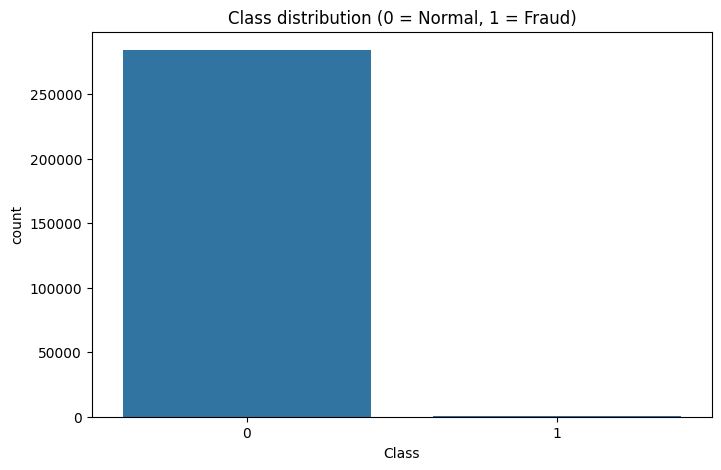

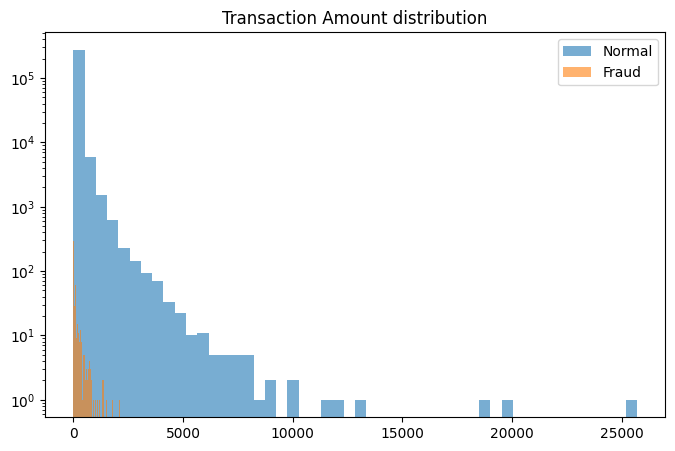

In [8]:
# Visualize class imbalance
sns.countplot(x='Class', data=df)
plt.title('Class distribution (0 = Normal, 1 = Fraud)')
plt.show()

# Amount distribution (log scale to visualize)
plt.hist(df[df['Class']==0]['Amount'], bins=50, alpha=0.6, label='Normal')
plt.hist(df[df['Class']==1]['Amount'], bins=50, alpha=0.6, label='Fraud')
plt.legend()
plt.title('Transaction Amount distribution')
plt.yscale('log')
plt.show()


3. Preprocessing (Scaling + Train/Test split)

In [10]:
# Feature and target separation

x = df.drop(['Class'],axis=1)
y = df['Class'].values  

scaler = StandardScaler()
x['scaled_amount'] = scaler.fit_transform(x['Amount'].values.reshape(-1,1))
x['scaled_time'] = scaler.fit_transform(x['Time'].values.reshape(-1,1))
x = x.drop(['Time','Amount'],axis=1)

x_values = x.values
print(f"Feature set shape: {x_values.shape}")
print(f"Target set shape: {y.shape}")

x_train,x_test,y_train,y_test = train_test_split(
    x_values,y,test_size=0.2,random_state=SEED,stratify=y
)

print(f"Training set shape: {x_train.shape}, {y_train.shape}")
print(f"Testing set shape: {x_test.shape}, {y_test.shape}")

Feature set shape: (284807, 30)
Target set shape: (284807,)
Training set shape: (227845, 30), (227845,)
Testing set shape: (56962, 30), (56962,)


4. ANN Builder Function

In [13]:
def build_model(input_dim,l2_reg=1e-4,dropout_rate=0.3):
    model = Sequential()

    model.add(Dense(64,activation='relu',input_dim=input_dim,kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(32,activation='relu',kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(16,activation='relu',kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    return model

model = build_model(input_dim=x_train.shape[1])
model.summary()                                                                                     

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 4,833 (18.88 KB)

 Non-trainable params: 224 (896.00 B)

5. Utility: Training & Evaluation Helpers

In [14]:
def fit_model(model, X_tr, y_tr, X_val, y_val, epochs=150, batch_size=2048, class_weight=None):
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
    )

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return history

def evaluate_model(model, X_te, y_te, threshold=0.5, show_plots=True):
    y_proba = model.predict(X_te).ravel()
    y_pred = (y_proba >= threshold).astype(int)
    print("Classification Report:")
    print(classification_report(y_te, y_pred, digits=4))
    cm = confusion_matrix(y_te, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'])
    plt.title(f'Confusion Matrix (threshold={threshold})')
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Precision-Recall and AP
    precision, recall, _ = precision_recall_curve(y_te, y_proba)
    ap = average_precision_score(y_te, y_proba)
    print(f"PR-AUC (Average Precision): {ap:.4f}")
    if show_plots:
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(recall, precision, label=f'AP = {ap:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()

    return y_proba

6. Experiment A — Baseline ANN (No imbalance handling)

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 4,833 (18.88 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7004 - loss: 0.6628 - val_accuracy: 0.9983 - val_loss: 0.4554 - learning_rate: 0.0010
Epoch 2/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9438 - loss: 0.3867 - val_accuracy: 0.9993 - val_loss: 0.2279 - learning_rate: 0.0010
Epoch 3/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9924 - loss: 0.1804 - val_accuracy: 0.9993 - val_loss: 0.1107 - learning_rate: 0.0010
Epoch 4/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9970 - loss: 0.0925 - val_accuracy: 0.9993 - val_loss: 0.0623 - learning_rate: 0.0010
Epoch 5/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9979 - loss: 0.0593 - val_accuracy: 0.9993 - val_loss: 0.0439 - learning_rate: 0.0010
Epoch 6/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9986 - loss: 0.0436 - val_accuracy: 0.9993 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 7/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9986 - loss: 0

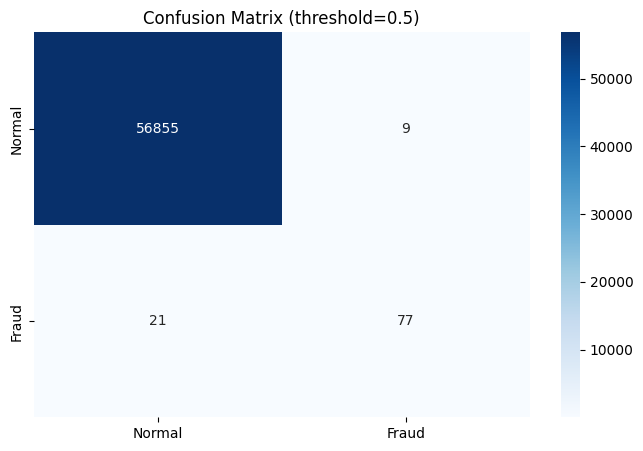

ROC AUC: 0.9873
PR-AUC (Average Precision): 0.8774


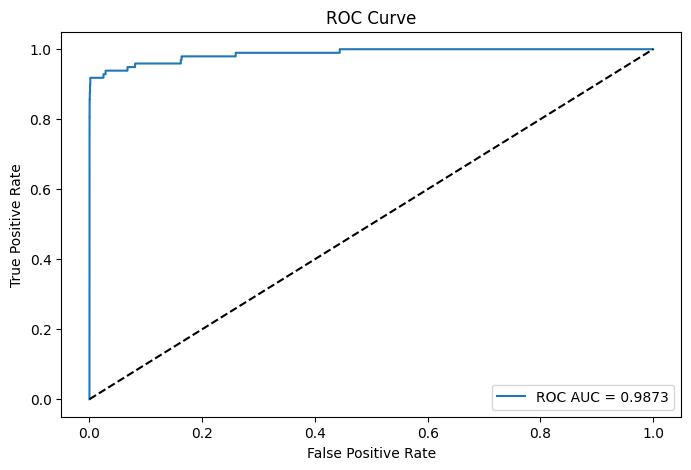

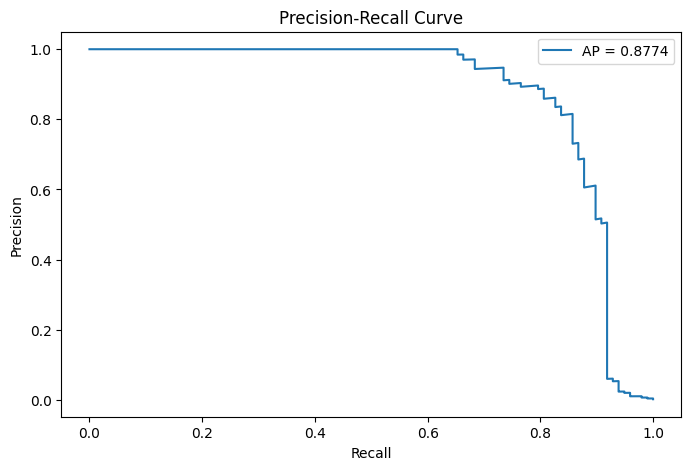

In [15]:
base_model = build_model(input_dim=x_train.shape[1])
base_model.summary()
history_base = fit_model(base_model,x_train,y_train,x_test,y_test,epochs=150,batch_size=2048)
y_proba_base = evaluate_model(base_model,x_test,y_test)

7. Experiment B — ANN with Class Weights

Class weights: {0: np.float64(0.5008661206149896), 1: np.float64(289.14340101522845)}


C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5804 - loss: 0.6231 - val_accuracy: 0.9090 - val_loss: 0.5357 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7888 - loss: 0.3842 - val_accuracy: 0.9687 - val_loss: 0.3595 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8867 - loss: 0.3199 - val_accuracy: 0.9644 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9238 - loss: 0.2690 - val_accuracy: 0.9741 - val_loss: 0.2298 - learning_rate: 0.0010
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9434 - loss: 0.2393 - val_accuracy: 0.9799 - val_loss: 0.1920 - learning_rate: 0.0010
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9540 - loss: 0.2250 - val_accuracy: 0.9840 - val_loss: 0.1633 - learning_rate: 0.0010
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9594 - loss: 0.196

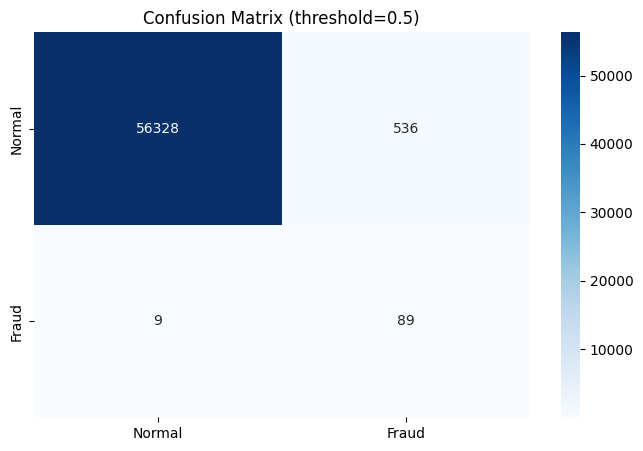

ROC AUC: 0.9735
PR-AUC (Average Precision): 0.7215


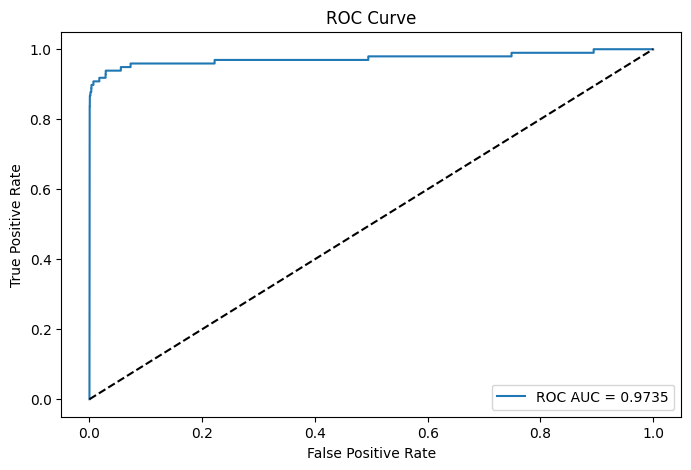

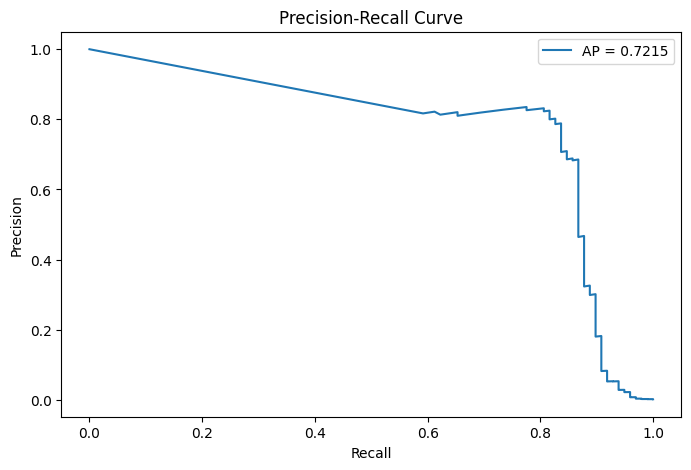

In [16]:
# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

cw_model = build_model(input_dim=x_train.shape[1])
history_cw = fit_model(cw_model, x_train, y_train, x_test, y_test, epochs=50, batch_size=2048, class_weight=class_weight_dict)
y_proba_cw = evaluate_model(cw_model, x_test, y_test)


8. Experiment C — SMOTE Oversampling

Resampled train shape: (454902, 30) [227451 227451]


C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9149 - loss: 0.2325 - val_accuracy: 0.9675 - val_loss: 0.1042 - learning_rate: 0.0010
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9693 - loss: 0.0960 - val_accuracy: 0.9838 - val_loss: 0.0572 - learning_rate: 0.0010
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9821 - loss: 0.0614 - val_accuracy: 0.9904 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9883 - loss: 0.0449 - val_accuracy: 0.9941 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9917 - loss: 0.0352 - val_accuracy: 0.9954 - val_loss: 0.0242 - learning_rate: 0.0010
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9942 - loss: 0.0285 - val_accuracy: 0.9966 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9952 - loss: 0.0248 

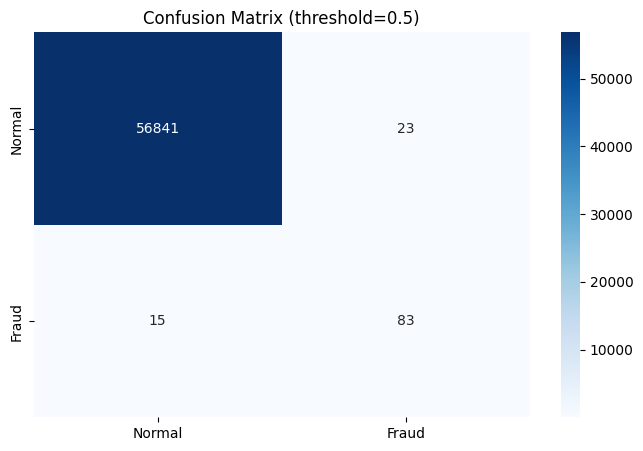

ROC AUC: 0.9713
PR-AUC (Average Precision): 0.8424


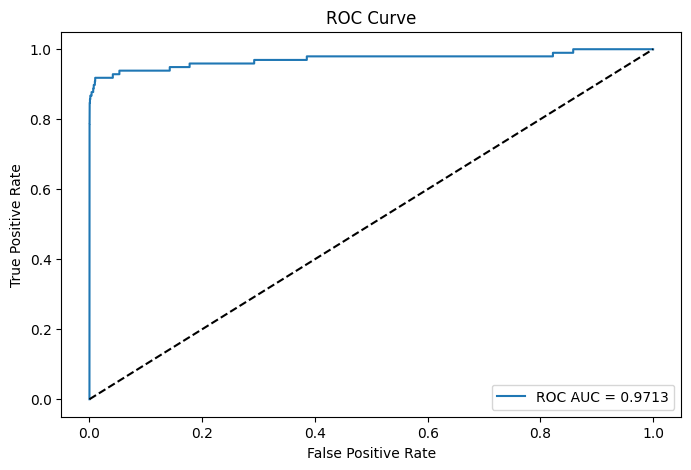

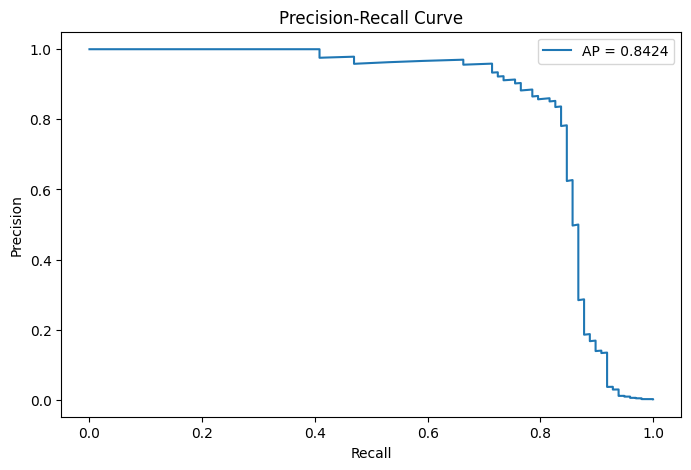

In [18]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on training set
sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(x_train, y_train)
print("Resampled train shape:", X_res.shape, np.bincount(y_res))

smote_model = build_model(input_dim=X_res.shape[1])
# We will train with validation_data as test set here
history_sm = fit_model(smote_model, X_res, y_res, x_test, y_test, epochs=50, batch_size=2048)
y_proba_sm = evaluate_model(smote_model, x_test, y_test)


9. Experiment D — Random Undersampling

Undersampled train shape: (788, 30) [394 394]


C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5266 - loss: 0.8204 - val_accuracy: 0.1350 - val_loss: 0.8818 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5533 - loss: 0.7721 - val_accuracy: 0.1292 - val_loss: 0.8853 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5508 - loss: 0.7458 - val_accuracy: 0.1250 - val_loss: 0.8875 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6053 - loss: 0.7199 - val_accuracy: 0.1227 - val_loss: 0.8885 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6536 - loss: 0.6594 - val_accuracy: 0.1272 - val_loss: 0.8857 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6409 - loss: 0.6357 - val_accuracy: 0.1320 - val_loss: 0.8820 - learning_rate: 5.0000e-04
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Classification Report:
              precision    re

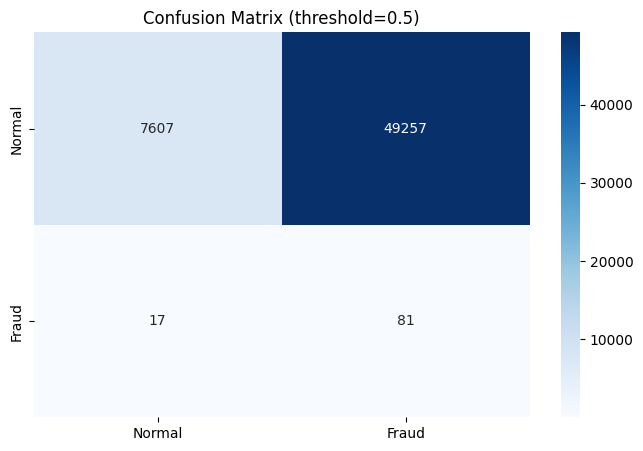

ROC AUC: 0.6911
PR-AUC (Average Precision): 0.0535


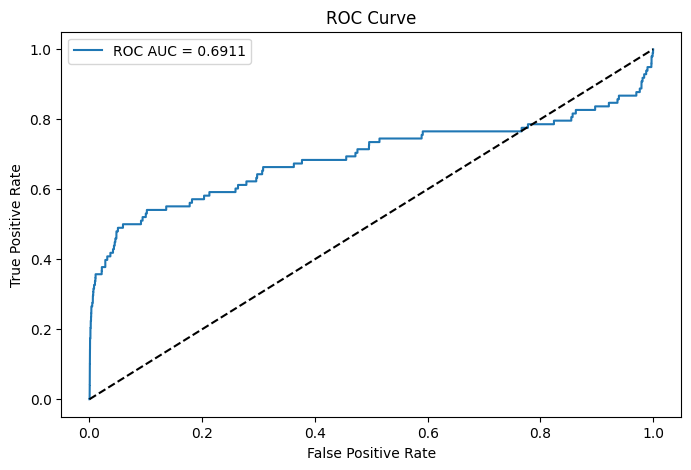

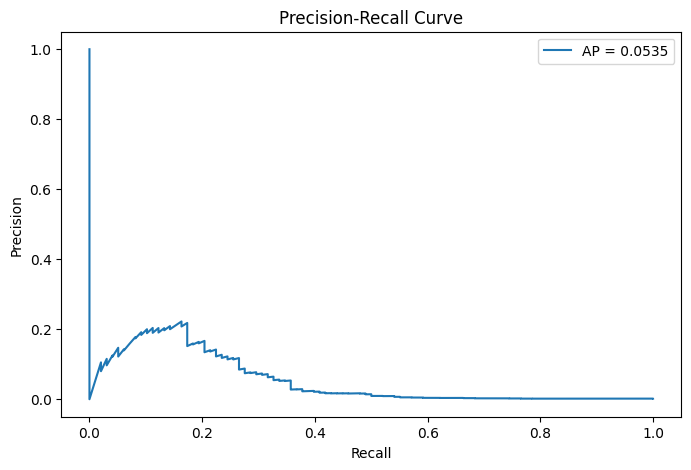

In [19]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=SEED)
X_rus, y_rus = rus.fit_resample(x_train, y_train)
print("Undersampled train shape:", X_rus.shape, np.bincount(y_rus))

rus_model = build_model(input_dim=X_rus.shape[1])
history_rus = fit_model(rus_model, X_rus, y_rus, x_test, y_test, epochs=50, batch_size=2048)
y_proba_rus = evaluate_model(rus_model, x_test, y_test)


10. Compare Methods

In [20]:
# Compare basic metrics (ROC-AUC and AP) computed earlier. We can compute directly:
from sklearn.metrics import roc_auc_score, average_precision_score

results = {
    "Baseline": (roc_auc_score(y_test, y_proba_base), average_precision_score(y_test, y_proba_base)),
    "ClassWeights": (roc_auc_score(y_test, y_proba_cw), average_precision_score(y_test, y_proba_cw)),
    "SMOTE": (roc_auc_score(y_test, y_proba_sm), average_precision_score(y_test, y_proba_sm)),
    "Undersample": (roc_auc_score(y_test, y_proba_rus), average_precision_score(y_test, y_proba_rus))
}

res_df = pd.DataFrame.from_dict(results, orient='index', columns=['ROC_AUC','PR_AUC'])
res_df


,ROC_AUC,PR_AUC
Baseline,0.987349,0.877428
ClassWeights,0.973527,0.721501
SMOTE,0.971257,0.842375
Undersample,0.691115,0.053506


11. Baseline: Logistic Regression Comparison

In [21]:
# Small logistic regression baseline (use scaled features X_train/X_test)
print("Training Logistic Regression baseline (with class_weight='balanced') ...")
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
lr.fit(x_train, y_train)
lr_proba = lr.predict_proba(x_test)[:,1]

print("Logistic ROC-AUC:", roc_auc_score(y_test, lr_proba))
print("Logistic PR-AUC:", average_precision_score(y_test, lr_proba))


Training Logistic Regression baseline (with class_weight='balanced') ...
Logistic ROC-AUC: 0.9721669425367221
Logistic PR-AUC: 0.7189463752156904
